## TUTORIAL 04 - Graetz problem 1
**_Keywords: successive constraints method_**

### 1. Introduction
This Tutorial addresses geometrical parametrization and the successive constraints method (SCM). In particular, we will solve the Graetz problem, which deals with forced heat convection in a channel $\Omega_o(\mu_0)$ divided into two parts $\Omega_o^1$ and $\Omega_o^2(\mu_0)$.

Boundaries $\Gamma_{o, 1} \cup \Gamma_{o, 5} \cup \Gamma_{o, 6}$ are kept at low temperature (say, zero), while boundaries $\Gamma_{o, 2}(\mu_0) \cup \Gamma_{o, 4}(\mu_0)$ are kept at high temperature (say, one). The convection is characterized by the velocity $\boldsymbol{\beta} = (x_1(1-x_1), 0)$, being $\boldsymbol{x}_o = (x_{o, 0}, x_1)$ the coordinate vector on the parametrized domain $\Omega_o(\mu_0)$.

The problem is characterized by two parameters. The first parameter $\mu_0$ controls the shape of deformable subdomain $\Omega_2(\mu_0)$. The heat transfer between the domains can be taken into account by means of the Péclet number, which will be labeled as the parameter $\mu_1$. The ranges of the two parameters are the following:
$$\mu_0 \in [0.1,10.0] \quad \text{and} \quad \mu_1 \in [0.01,10.0].$$

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0, \mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10.0]\times[0.01,10.0].
$$

In order to obtain a faster (yet, provably accurate) approximation of the problem, and avoiding _any_ remeshing, we pursue a model reduction by means of a certified reduced basis reduced order method from a fixed reference domain.
The successive constraints method will be used to evaluate the stability factors.

### 2. Parametrized formulation

Let $u_o(\boldsymbol{\mu})$ be the temperature in the domain $\Omega_o(\mu_0)$.

We will directly provide a weak formulation for this problem: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u_o(\boldsymbol{\mu})\in\mathbb{V}_o(\boldsymbol{\mu})$ such that

$$a_o\left(u_o(\boldsymbol{\mu}),v_o;\boldsymbol{\mu}\right)=f_o(v_o;\boldsymbol{\mu})\quad \forall v_o\in\mathbb{V}_o(\boldsymbol{\mu})$$

where

* the function space $\mathbb{V}_o(\boldsymbol{\mu})$ is defined as
$$
\mathbb{V}_o(\mu_0) = \left\{ v \in H^1(\Omega_o(\mu_0)): v|_{\Gamma_{o,1} \cup \Gamma_{o,5} \cup \Gamma_{o,6}} = 0, v|_{\Gamma_{o,2}(\mu_0) \cup \Gamma_{o,2}(\mu_0)} = 1 \right\}
$$
Note that, as in the previous tutorial, the function space is parameter dependent due to the shape variation. 
* the parametrized bilinear form $a_o(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V}_o(\boldsymbol{\mu}) \times \mathbb{V}_o(\boldsymbol{\mu}) \to \mathbb{R}$ is defined by
$$a_o(u_o,v_o;\boldsymbol{\mu}) = \mu_1\int_{\Omega_o(\mu_0)} \nabla u_o \cdot \nabla v_o \ d\boldsymbol{x} + \int_{\Omega_o(\mu_0)} x_1(1-x_1) \partial_{x} u_o\ v_o \ d\boldsymbol{x},$$
* the parametrized linear form $f_o(\cdot; \boldsymbol{\mu}): \mathbb{V}_o(\boldsymbol{\mu}) \to \mathbb{R}$ is defined by
$$f_o(v_o;\boldsymbol{\mu}) = 0.$$

The successive constraints method will be used to compute the stability factor of the bilinear form $a_o(\cdot, \cdot; \boldsymbol{\mu})$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

In order to obtain an affine decomposition, we proceed as in the previous tutorial and recast the problem on a fixed, parameter _independent_, reference domain $\Omega$. As reference domain which choose the one characterized by $\mu_0 = 1$ which we generate through the generate_mesh notebook provided in the _data_ folder.
As in the previous tutorial, we pull back the problem to the reference domain $\Omega$.

In [2]:
@SCM()
@PullBackFormsToReferenceDomain()
@ShapeParametrization(
    ("x[0]", "x[1]"),  # subdomain 1
    ("mu[0]*(x[0] - 1) + 1", "x[1]"),  # subdomain 2
)
class Graetz(EllipticCoerciveProblem):

    # Default initialization of members
    @generate_function_space_for_stability_factor
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.ds = Measure("ds")(subdomain_data=boundaries)
        # Store the velocity expression
        self.vel = Expression("x[1]*(1-x[1])", element=self.V.ufl_element())
        # Customize eigen solver parameters
        self._eigen_solver_parameters.update({
            "bounding_box_minimum": {
                "problem_type": "gen_hermitian", "spectral_transform": "shift-and-invert",
                "spectral_shift": 1.e-5, "linear_solver": "mumps"
            },
            "bounding_box_maximum": {
                "problem_type": "gen_hermitian", "spectral_transform": "shift-and-invert",
                "spectral_shift": 1.e5, "linear_solver": "mumps"
            },
            "stability_factor": {
                "problem_type": "gen_hermitian", "spectral_transform": "shift-and-invert",
                "spectral_shift": 1.e-5, "linear_solver": "mumps"
            }
        })

    # Return custom problem name
    def name(self):
        return "Graetz1"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_stability_factor
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[1]
            theta_a1 = 1.0
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = 1.0
            return (theta_f0,)
        elif term == "dirichlet_bc":
            theta_bc0 = 1.0
            return (theta_bc0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_stability_factor
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            vel = self.vel
            a0 = inner(grad(u), grad(v)) * dx
            a1 = vel * u.dx(0) * v * dx
            return (a0, a1)
        elif term == "f":
            f0 = Constant(0.0) * v * dx
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(1.0), self.boundaries, 2),
                   DirichletBC(self.V, Constant(1.0), self.boundaries, 4),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 5),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 6)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh_1.ipynb](data/generate_mesh_1.ipynb) notebook.

In [3]:
mesh = Mesh("data/graetz_1.xml")
subdomains = MeshFunction("size_t", mesh, "data/graetz_physical_region_1.xml")
boundaries = MeshFunction("size_t", mesh, "data/graetz_facet_region_1.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the Graetz class

In [5]:
problem = Graetz(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (0.01, 10.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = ReducedBasis(problem)
reduction_method.set_Nmax(30, SCM=20)
reduction_method.set_tolerance(1e-5, SCM=1e-3)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
lifting_mu = (1.0, 1.0)
problem.set_mu(lifting_mu)
reduction_method.initialize_training_set(200, SCM=250)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \|A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2 + \left|\operatorname{N}_W(\boldsymbol{\mu}^{(i)})_1 - 1\right|^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the pull back of $a_o$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the pull back of $f_o$. 

The second term in the sum enforces boundary conditions by training the first basis function coefficient to be one, as our first basis function contains the boundary condition while all other basis functions are zero on the boundary.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=20)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=10)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 'stability_factor_left_hand_matrix' not implemented. Continuing without operator 'stability_factor_left_hand_matrix'...
Operator 'stability_factor_right_hand_matrix' not implemented. Continuing without operator 'stability_factor_right_hand_matrix'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 'stability_factor_left_hand_matrix' not implemented. Continuing without operator 'stability_factor_left_hand_matrix'...
Operator 'stability_factor_right_hand_matrix' not implemented. Continuing without operator 'stability_factor_right_hand_matrix'...
9500 0.9556554141719497 	Loss(validation) = 0.9807080549862907
9600 0.9552235163125211 	Loss(validation) = 0.9807107831591336
9700 0.9549565538263871 	Loss(validation) = 0.9800460660421448
9800 0.9544084964891886 	Loss(validation) = 0.9806527483921126
9900 0.9542789028268166 	Loss(validation) = 0.9797767479085692
10000 0.9536237436281243 	Loss(vali

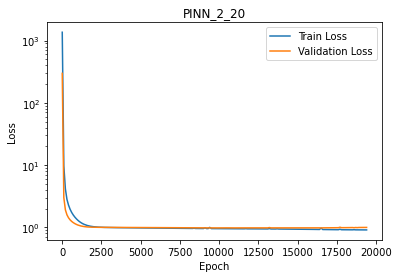

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [11]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [12]:
pdnn_trainer.train()

5100 2.0024883295364758e-05 	Loss(validation) = 0.006722415344847246
5200 1.8230122428151282e-05 	Loss(validation) = 0.006748650583337317
5300 1.6662578133314653e-05 	Loss(validation) = 0.006765096027854
5400 1.821235961140005e-05 	Loss(validation) = 0.006794006974797121
5500 1.4106609179171454e-05 	Loss(validation) = 0.006791509600129072
5600 1.385026011599172e-05 	Loss(validation) = 0.006904543533875877
5700 1.2479476240354981e-05 	Loss(validation) = 0.006835561521743855
5800 1.1793746669731522e-05 	Loss(validation) = 0.007038657845883486
5900 1.0609620783712627e-05 	Loss(validation) = 0.006956382201081457
6000 9.292242001713446e-06 	Loss(validation) = 0.007008926397625228
6100 8.750253875881986e-06 	Loss(validation) = 0.0070656976480392856
6200 7.971325850687018e-06 	Loss(validation) = 0.007078327188894809
6300 1.563909806112882e-05 	Loss(validation) = 0.007137864613654465
6400 7.231208365577303e-06 	Loss(validation) = 0.007169493843041877
6500 6.279097786440669e-06 	Loss(validation

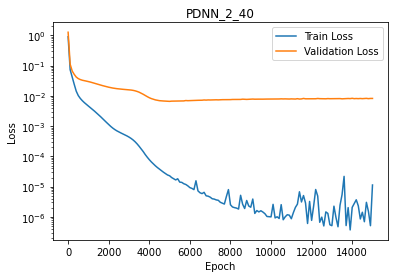

In [13]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [14]:
input_normalization_prnn = Normalization.IdentityNormalization(input_normalization=True)
output_normalization_prnn = Normalization.IdentityNormalization()

omega = 100.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [15]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 'stability_factor_left_hand_matrix' not implemented. Continuing without operator 'stability_factor_left_hand_matrix'...
Operator 'stability_factor_right_hand_matrix' not implemented. Continuing without operator 'stability_factor_right_hand_matrix'...
Operator 's' not implemented. Continuing without operator 's'...
Operator 'stability_factor_left_hand_matrix' not implemented. Continuing without operator 'stability_factor_left_hand_matrix'...
Operator 'stability_factor_right_hand_matrix' not implemented. Continuing without operator 'stability_factor_right_hand_matrix'...
4500 6.108352055766794 	Loss(validation) = 8.563183892021087
4600 6.0814228688583825 	Loss(validation) = 8.560678841257632
4700 6.05537661211976 	Loss(validation) = 8.558762070995412
4800 6.047368095695887 	Loss(validation) = 8.57934132556074
4900 6.014035086966645 	Loss(validation) = 8.567415378206057
5000 5.989689168230827 	Loss(validation) = 8.5

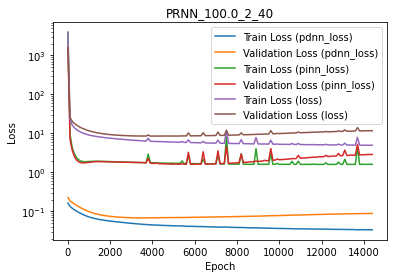

In [16]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [17]:
reduction_method.initialize_testing_set(100, SCM=100)
reduction_method.error_analysis(filename="error_analysis")

=                          SCM error analysis begins                           =

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 0 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 1 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 2 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 3 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 4 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 5 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 6 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 7 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 8 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 9 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 10 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SCM 99 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

N 	min(normalized_error) 	gmean(normalized_error)	max(normalized_error)
1 	0.003022070682074032  	0.13925944078915956    	0.9256335134488062   
2 	0.003022070682073669  	0.15739055418412204    	0.9094592913121833   
3 	0.0003934361198156536 	0.029647202318832562   	0.20000622675123497  
4 	0.00039343611981179085	0.02914177939748637    	0.1991104909285588   
5 	0.00039343611981579156	0.02446899573917232    	0.19173443154000386  
6 	1.5503969793298845e-05	0.002660131832441949   	0.03149148993861569  
7 	1.107402074043885e-05 	0.0005104203845785066  	0.024746945691205918 
8 	8.437572038872452e-08 	6.705419875337893e-05  	0.014298591847858868 
9 	8.437571950365566e-08 	6.310334205110583e-05  	0.014298591847858868 
10	8.437571879560059e-08 	6.257895054429984e-05  	0.014298591847858715 
11	8.437572091976583e-08 	6.226984053946452e-05  	0.014271667688134308 
12	8.43757210967796e-08  	5.748975133538068e-05  	0.01

###################################### 76 ######################################
###################################### 77 ######################################
###################################### 78 ######################################
###################################### 79 ######################################
###################################### 80 ######################################
###################################### 81 ######################################
###################################### 82 ######################################
###################################### 83 ######################################
###################################### 84 ######################################
###################################### 85 ######################################
###################################### 86 ######################################
###################################### 87 ######################################
############################

#### 4.6.2 PINN Error Analysis

In [18]:
test_mu = torch.tensor(reduction_method.testing_set)

In [19]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

#################################### N = 22 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.5666270247886503	0.566627170040767	6.4969698074493e-07
mean	1.003233093730537	1.0032330880667557	1.2133997931467735e-05
max	1.308647211594794	1.3086472098709645	9.265282029707318e-05


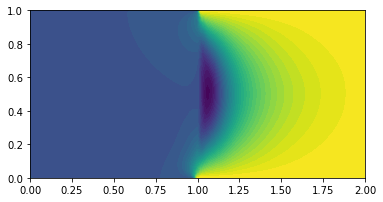

In [20]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (10.0, 0.01), input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [21]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

#################################### N = 22 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0010095916788865687	0.0010095830242042513	6.4969698074493e-07
mean	0.04761122384255352	0.047611244656785845	1.2133997931467735e-05
max	0.125975256688538	0.12597529150682985	9.265282029707318e-05


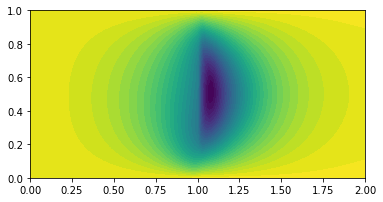

In [22]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (10.0, 0.01), input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [23]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 22 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.042713453397129196	0.04271345351014652	6.4969698074493e-07
mean	0.8279679959349648	0.8279679866261525	1.2133997931467735e-05
max	1.0195487106582322	1.0195487181766416	9.265282029707318e-05


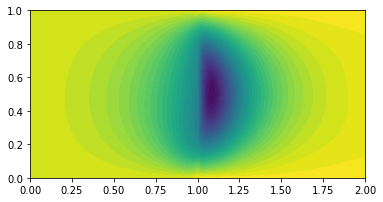

In [24]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (10.0, 0.01), input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [25]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for 22 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	1.003233093730537	1.0032330880667557	1.2133997931467735e-05
pdnn_net	0.04761122384255352	0.047611244656785845	1.2133997931467735e-05
prnn_net	0.8279679959349648	0.8279679866261525	1.2133997931467735e-05
#####################################################################################


### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.speedup_analysis(filename="speedup_analysis")